In [1]:
!pip install GPUtil
import scipy.io
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import random
from PIL import Image
import glob
import math
import os
from IPython.display import HTML
import struct
import kornia
from skimage import feature
from GPUtil import showUtilization as gpu_usage
from torch.nn.utils.weight_norm import weight_norm

  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7410 sha256=2c584784accbf95e69ea4fc32441f85aa217a33731a1abe7f6a40c38ec1566eb
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
DATA_FOLDER = "/kaggle/input/the-small-norb-dataset-v10/"

PREFIXES = {
    'train': 'smallnorb-5x46789x9x18x6x2x96x96-training-',
    'test': 'smallnorb-5x01235x9x18x6x2x96x96-testing-',
}

FILE_TYPES = ['info', 'cat', 'dat']

# helper function to read int from file
def read_int(f):
    num, = struct.unpack('i', f.read(4))
    return num


# From https://cs.nyu.edu/~ylclab/data/norb-v1.0-small/ 
# "The magic number encodes the element type of the matrix"
# Note: I only copied over the ones I needed for these files.
map_magic_number_to_data_type = {
    '1e3d4c55': np.uint8,
    '1e3d4c54': np.int32,
}

loaded_data = {}

for dataset, prefix in PREFIXES.items():
    for filetype in FILE_TYPES:
        filename = prefix + filetype + ".mat"
        print('Reading {}'.format(filename))
        
        file_loc = os.path.join(DATA_FOLDER, filename)
        with open( file_loc, 'rb') as f:
            # Read the magic_num, convert it to hexadecimal, and look up the data_type
            raw_magic_num = read_int(f)
            magic_num = format(raw_magic_num, '02x')
            data_type = map_magic_number_to_data_type[magic_num]
            print('dtype', data_type)

            # Read how many dimensions to expect
            ndim = read_int(f)
            
            # Read at least 3 ints, or however many ndim there are
            shape = [
                read_int(f)
                for i in range(max(ndim, 3))
            ]   
            # But in case ndims < 3, take at most n_dim elements
            shape = shape[:ndim]
            print('shape', shape)
    
            # Now load the actual data!
            loaded_data[(dataset, filetype)] = np.fromfile(
                f, 
                dtype=data_type, 
                count=np.prod(shape)
            ).reshape(shape)

Reading smallnorb-5x46789x9x18x6x2x96x96-training-info.mat
dtype <class 'numpy.int32'>
shape [24300, 4]
Reading smallnorb-5x46789x9x18x6x2x96x96-training-cat.mat
dtype <class 'numpy.int32'>
shape [24300]
Reading smallnorb-5x46789x9x18x6x2x96x96-training-dat.mat
dtype <class 'numpy.uint8'>
shape [24300, 2, 96, 96]
Reading smallnorb-5x01235x9x18x6x2x96x96-testing-info.mat
dtype <class 'numpy.int32'>
shape [24300, 4]
Reading smallnorb-5x01235x9x18x6x2x96x96-testing-cat.mat
dtype <class 'numpy.int32'>
shape [24300]
Reading smallnorb-5x01235x9x18x6x2x96x96-testing-dat.mat
dtype <class 'numpy.uint8'>
shape [24300, 2, 96, 96]


In [3]:
x_raw = torch.Tensor(loaded_data[('train', 'dat')]) / 255.
y = torch.Tensor(loaded_data[('train', 'cat')])
info = torch.Tensor(loaded_data[('train', 'info')])
x = torch.zeros(5,5,972,2,96,96)
count = 0
instances = [4,6,7,8,9]

for lab in range(5):
    
    for ins in range(5):
        
        count=0
        
        for lig in range(6):
        
            for ele in range(9):
            
                for azi in range(18):
                    
                    x[lab,ins,count] = \
                        x_raw[(y==lab)&\
                        (info[:,0]==instances[ins])&\
                        (info[:,1]==ele)&\
                        (info[:,2]==azi*2)&\
                        (info[:,3]==lig)]
                    count += 1

In [4]:
x = x.view(-1, 1, 96, 96)
x = x[:,:,10:-10,10:-10][torch.randperm(x.shape[0])].cuda()

In [5]:
N_TEMP = 80
T_SIZE = 13
F_COMP = 5
TAU = 0.1

In [6]:
class StructSpars(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        self.expander = weight_norm(nn.Conv2d(1, N_TEMP, T_SIZE, bias=False))
        
        self.encoder = nn.Conv2d(N_TEMP, N_TEMP, F_COMP, padding=F_COMP//2, bias=False)
                
        self.inhibitor = nn.Conv2d(N_TEMP, N_TEMP, F_COMP, padding=F_COMP//2, bias=True)

        self.decoder = weight_norm(nn.ConvTranspose2d(N_TEMP, N_TEMP, T_SIZE, groups=N_TEMP, bias=False))
                
        self.blender =  nn.Conv2d(N_TEMP, N_TEMP, F_COMP, padding=F_COMP//2, bias=True)
        
        
    def forward(self, x):
        
        expanded = torch.relu(self.expander(x))
        
        code = torch.relu(self.encoder(expanded))
                
        inh_factors = self.inhibitor(expanded)
        
        inh_tiles = F.unfold(inh_factors, F_COMP*2, stride=F_COMP) 
                        
        inh_tiles = F.gumbel_softmax(inh_tiles, TAU, dim=1)
                
        inh_mask = F.fold(inh_tiles, inh_factors.shape[-2:], F_COMP*2, stride=F_COMP)
                
        del inh_tiles, inh_factors, expanded
        
        overflow = inh_mask > 1.
        
        normaliser = torch.ones(inh_mask.shape, device=x.device) * (~ overflow) + overflow * inh_mask.detach()
        
        inh_mask = inh_mask / normaliser
            
        sparse_code = code * inh_mask
        
        del code, normaliser, overflow
        
        raw_reco = torch.relu(self.decoder(sparse_code))
                                
        ble_factors = self.blender(raw_reco)
        
        ble_mask = F.gumbel_softmax(ble_factors, TAU, dim=1)
                
        sparse_reco = raw_reco * ble_mask
        
        reco = torch.sum(sparse_reco, dim=1, keepdim=True)
                
        return reco, sparse_code, sparse_reco
    
    
    def get_templates(self):
        
        return self.decoder.weight.data
    
    def get_encoders(self):
        
        return self.expander.weight.data

In [7]:
def log_losses(reco, img, sparse_code, sparse_reco):
    
    diff = (reco - img) **2
    
    mse_loss = torch.mean(diff)
    
    activations = sparse_code.mean(dim=(0,2,3))

    code_spars_loss = (activations / activations.mean()).std()
                        
    activations = sparse_reco.mean(dim=(0,2,3))
        
    reco_spars_loss = (activations / activations.mean()).std()
    
    return 10*mse_loss, 0.1*code_spars_loss, 0.1*reco_spars_loss

In [8]:
def get_log(size, std):
    
    distance = torch.arange(size) - size//2
    
    x = distance.expand(1,1,size,size)**2
    
    y = x.transpose(-1,-2)
    
    t = (x + y) / (2*std**2)
    
    LoG = -1/(math.pi*std**4) * (1-t) * torch.exp(-t)
    
    return LoG

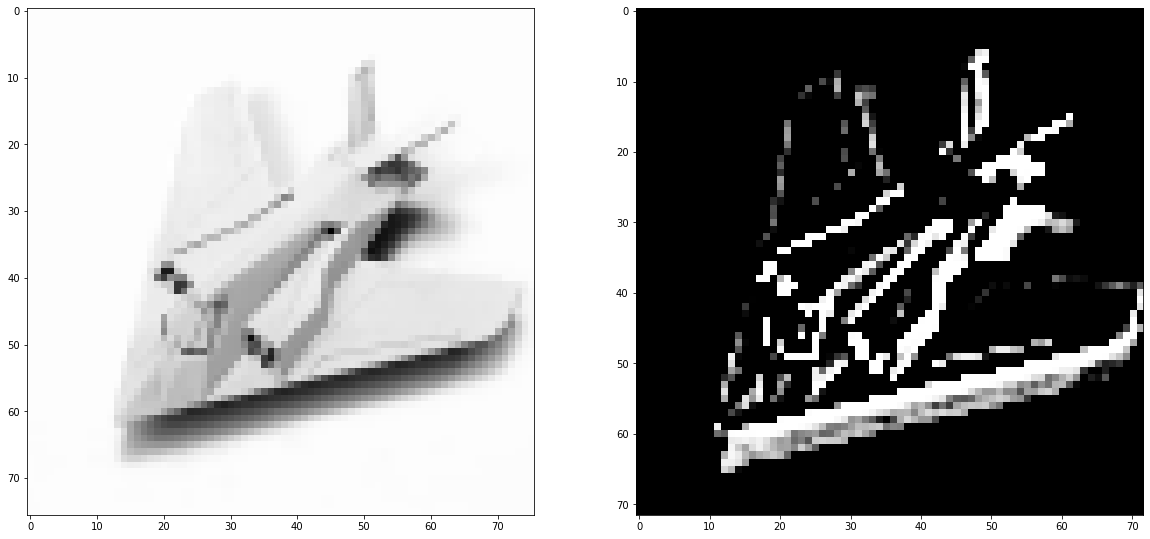

(tensor(0., device='cuda:0'),
 tensor(1., device='cuda:0'),
 tensor(0.0865, device='cuda:0'))

In [9]:
SHARPNESS = 75

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(x[1,0].detach().cpu(), cmap="gray")

log = get_log(5, 0.7).cuda()
x = F.conv2d(x, log)
x = torch.relu(x)
x = torch.sigmoid(x*SHARPNESS)

x = x - torch.min(x.reshape(x.shape[0], -1), dim=1)[0].view(-1,1,1,1)
x = x / torch.max(x.reshape(x.shape[0], -1), dim=1)[0].view(-1,1,1,1)

plt.subplot(1,2,2)
plt.imshow(x[1,0].detach().cpu(), cmap="gray")

plt.show()
x.min(), x.max(), x.mean()

In [10]:
split = (x.shape[0]//100)*80
xtrain = x[:split]
xval = x[split:]
xtrain.shape, xval.shape
del x

In [11]:
def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             
    torch.cuda.empty_cache()
    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()                           

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  3% | 23% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  3% | 11% |


In [12]:
def propagation(model, sample, b):
    
    reco, inh_mask, ble_mask = model(sample[b*B_SIZE:(b+1)*B_SIZE])
    
    mse, cod, tem = log_losses(reco, sample[b*B_SIZE:(b+1)*B_SIZE], inh_mask, ble_mask)
    
    loss = mse + cod + tem
    
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

In [13]:
def evaluation(model, sampleval, b):
    
    reco, inh_mask, ble_mask = model(sampleval[b*B_SIZE:(b+1)*B_SIZE])
    
    mse, cod, tem = log_losses(reco, sampleval[b*B_SIZE:(b+1)*B_SIZE], inh_mask, ble_mask)
    
    return mse, cod, tem

In [14]:
model = StructSpars().cuda()
optimiser = torch.optim.Adam(model.parameters())

In [15]:
EPOCHS = 80
B_SIZE = 162
nval = xval.shape[0] // B_SIZE
n_b = xtrain.shape[0] // B_SIZE
losstracker = torch.zeros((nval, 3)).cuda()
temptracker = torch.zeros((EPOCHS, N_TEMP*2, 1, T_SIZE, T_SIZE))

for e in range(EPOCHS): 

    temptracker[e,:N_TEMP] = model.get_templates().detach().cpu()
    temptracker[e,N_TEMP:] = model.get_encoders().detach().cpu()
    
    xtrain = xtrain[torch.randperm(xtrain.shape[0])]
    progress_bar = tqdm(range(n_b), position=0, leave=True)
    
    with torch.no_grad():
        
        for b in range(nval):
            
            losstracker[b,0],losstracker[b,1],losstracker[b,2] = \
                                                        evaluation(model, xval, b)
            
    progress_bar.set_description(\
                                    "E:"+ str(e) +\
                                    " MSE:" + format(losstracker[:,0].mean(),".3f") +\
                                    " COD:" + format(losstracker[:,1].mean(),".3f") +\
                                    " TEM:" + format(losstracker[:,2].mean(),".3f") +\
                                    " TOT:" + format(losstracker.sum(1).mean(),".3f"))
            
    for b in progress_bar:
        
        propagation(model, xtrain, b) 

E:79 MSE:0.228 COD:0.031 TEM:0.038 TOT:0.297: 100%|██████████| 240/240 [02:57<00:00,  1.35it/s]


In [16]:
torch.save(temptracker, 'temps.pt')
torch.save(model.state_dict(), 'weights.pth')

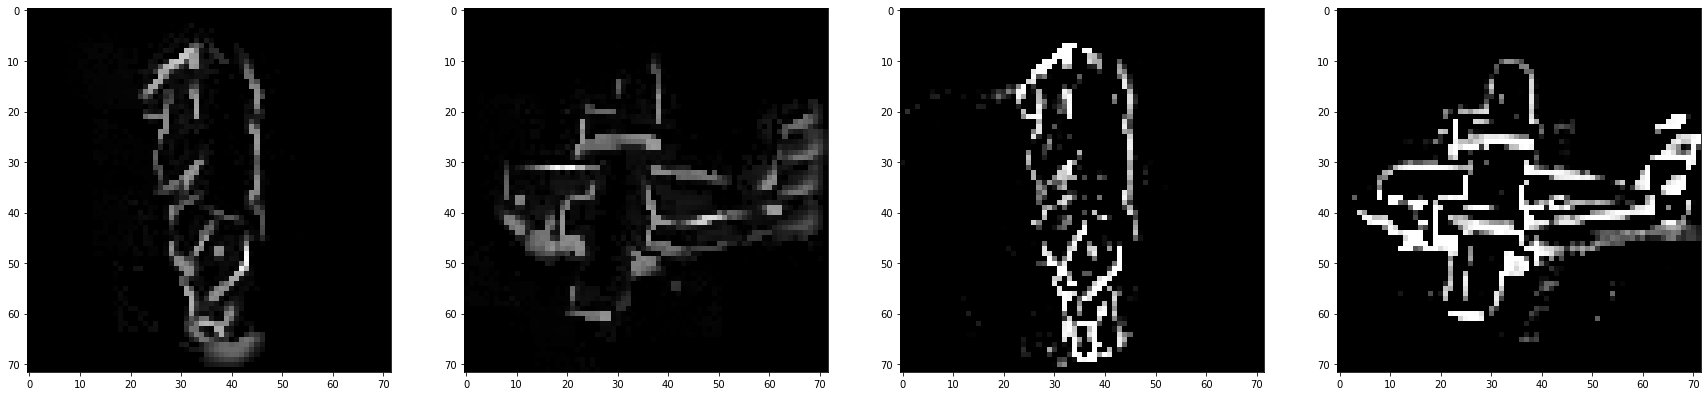

In [17]:
S = 56
testreco, code, blend = model(xval[S:S+2])
testreco = testreco.detach().cpu()
code = code.detach().cpu()
blend = blend.detach().cpu()

plt.figure(figsize=(30,10))
plt.subplot(1,4,1)
plt.imshow(testreco[0,0], cmap="gray")
plt.subplot(1,4,2)
plt.imshow(testreco[1,0], cmap="gray")
plt.subplot(1,4,3)
plt.imshow(xval[S,0].detach().cpu(), cmap="gray")
plt.subplot(1,4,4)
plt.imshow(xval[S+1,0].detach().cpu(), cmap="gray")
plt.show()

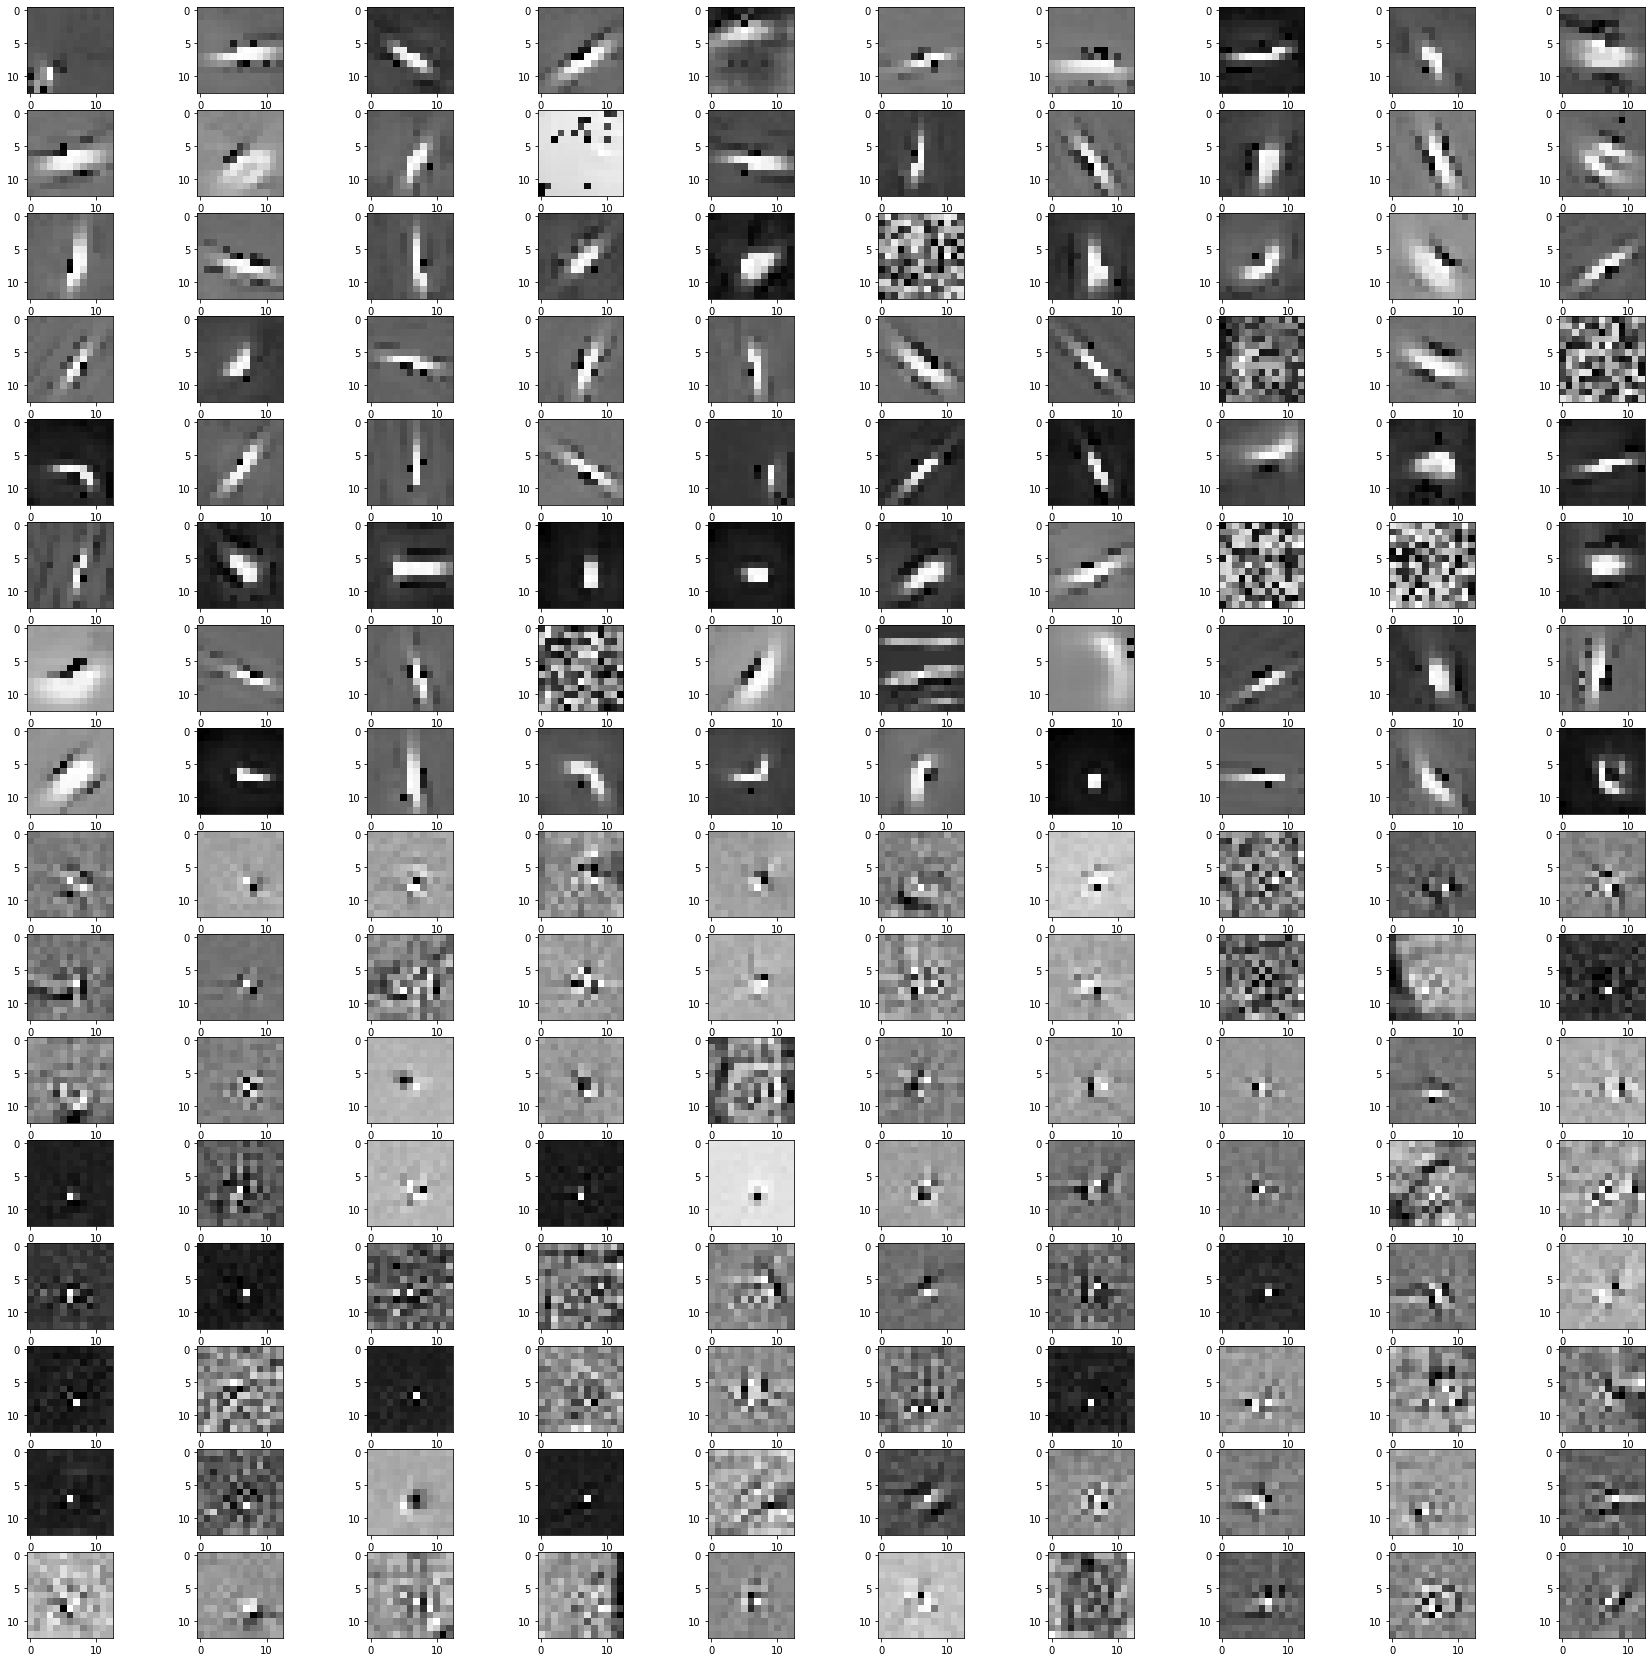

In [18]:
templates = model.get_templates().detach().cpu()
encoders = model.get_encoders().detach().cpu()
ROWS = 8

plt.figure(figsize=(30,30))

for i in range(N_TEMP):
    
    img = templates[i].permute(1,2,0)
    plt.subplot(ROWS*2, N_TEMP//ROWS, i+1)
    plt.imshow(img, cmap="gray")
    
for i in range(N_TEMP):
    
    img = encoders[i].permute(1,2,0)
    plt.subplot(ROWS*2, N_TEMP//ROWS, N_TEMP+i+1)
    plt.imshow(img, cmap="gray")
    
plt.show()

In [19]:
print((code.mean((0,-1,-2))*10000).round().int())
print((blend.mean((0,-1,-2))*10000).round().int())

tensor([13, 12, 11, 24,  0,  1, 26,  8,  0,  1, 15,  0, 19, 11, 30, 37,  0,  2,
        15, 15,  7, 22, 16,  9, 16,  0,  0, 25,  0,  6, 13, 17,  0,  0, 46,  0,
         3,  0, 12,  0, 13, 12, 40,  2, 23, 20, 12, 44, 35, 28, 23, 38, 14, 11,
        34,  0,  0,  0,  0, 20, 23,  5, 16,  0,  0,  0, 18,  8,  0,  0,  3, 34,
         0,  0, 23,  0, 26, 44,  0,  0], dtype=torch.int32)
tensor([ 1,  5,  8, 19,  0,  0, 13,  5,  0,  0,  6,  0, 12,  6, 13, 25,  0,  0,
         8,  9,  1, 16,  9,  7, 10,  0,  0, 20,  0,  4,  6, 17,  0,  0, 28,  0,
         2,  0,  5,  0,  8, 11, 29,  0, 19,  9,  6, 60, 30, 27, 10, 26,  8,  8,
        26,  0,  0,  0,  0,  3, 21,  4,  7,  0,  0,  0, 12,  3,  0,  0,  0, 19,
         0,  0, 15,  0, 15, 25,  0,  0], dtype=torch.int32)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  del sys.path[0]


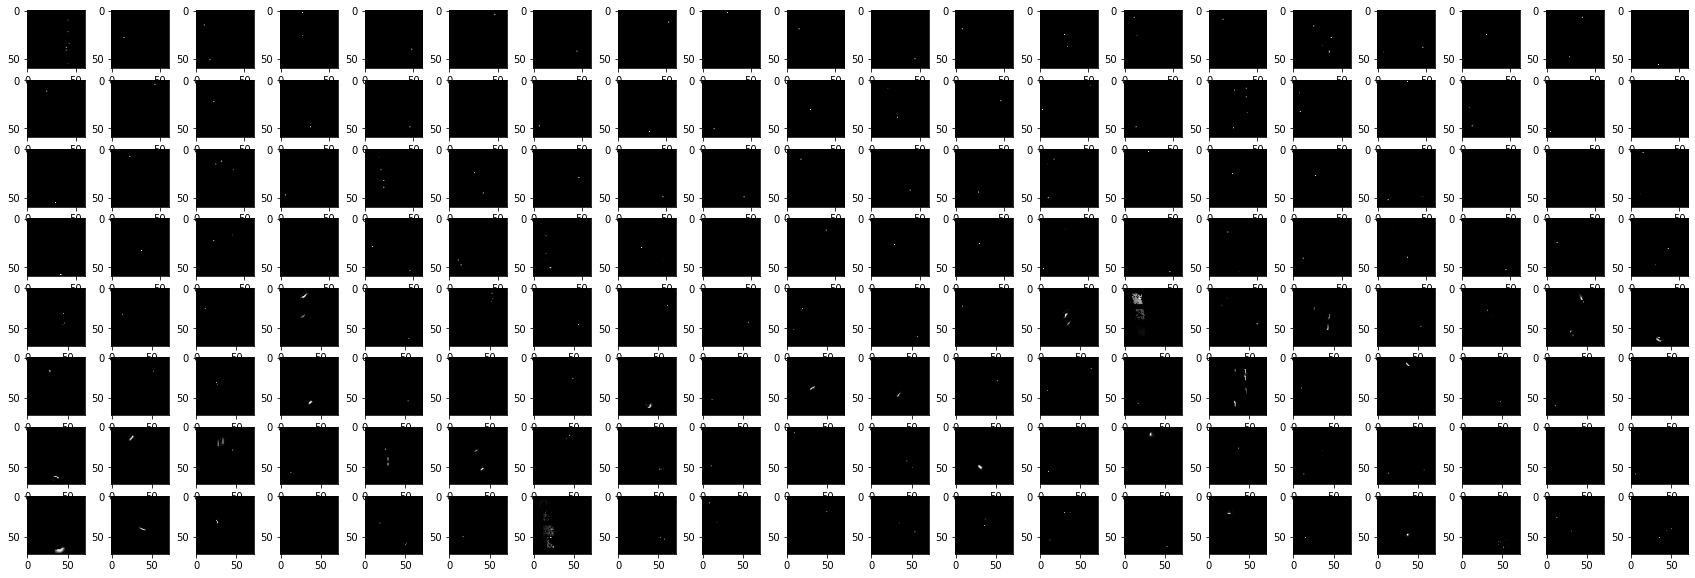

In [20]:
plt.figure(figsize=(30,10))
S1 = 3

for i in range(N_TEMP):
    
    img = code[0,i].detach().cpu()
    plt.subplot(8, N_TEMP/4, i+1)
    plt.imshow(img, cmap="gray")
    
for i in range(N_TEMP):
    
    img = blend[0,i].detach().cpu()
    plt.subplot(8, N_TEMP/4, N_TEMP+i+1)
    plt.imshow(img, cmap="gray")
    
plt.show()

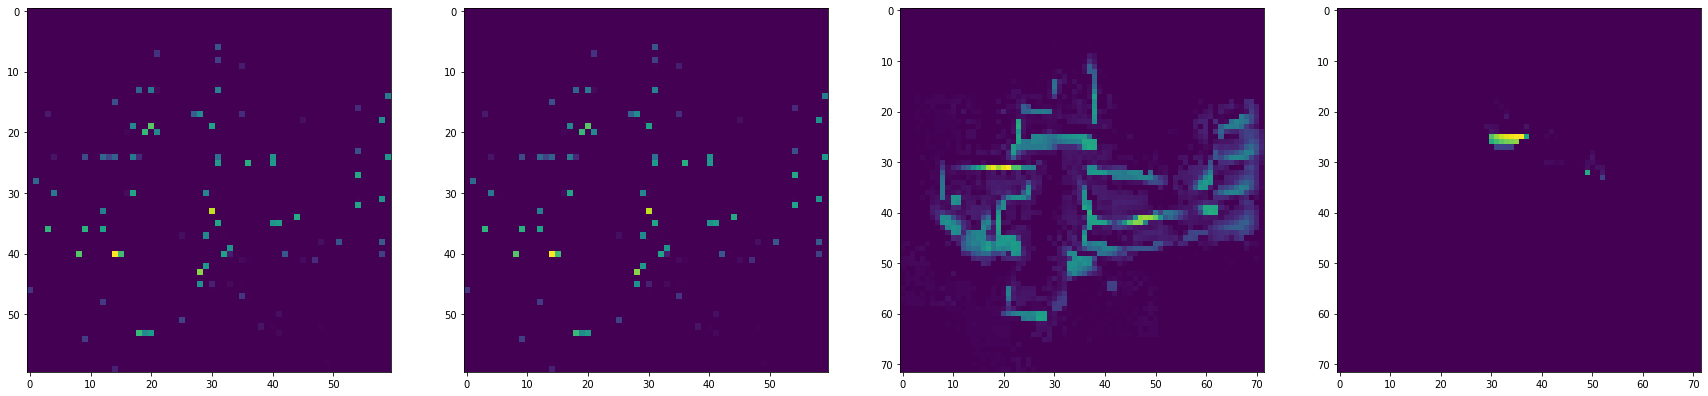

In [21]:
plt.figure(figsize=(30,10))
plt.subplot(1,4,1)
plt.imshow(code[1].mean((0)).detach().cpu())
plt.subplot(1,4,2)
plt.imshow(code[1].mean((0)).detach().cpu())
plt.subplot(1,4,3)
plt.imshow(blend[1].mean((0)).detach().cpu())
plt.subplot(1,4,4)
plt.imshow(blend[1,6].detach().cpu())

In [22]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

507360

In [23]:
# weight norm improved stability in training but too small problem